# Desafio #9

### Instalação de libs requeridas

In [1]:
!pip install opencv-python imutils

In [2]:
# Libs de apoio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display
import os , random , json , requests
import types
import pandas as pd

# Libs para criação de modelo DeepLearning
# ATENÇÃO - Não utilizar o Keras interno do Tensorflow por incompatibilidade com o WML
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import InputLayer
from keras.preprocessing import image as Kimage
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from imutils import paths

# Libs para comunicação APIs Watson IBM
from ibm_botocore.client import Config
import ibm_boto3
from watson_machine_learning_client import WatsonMachineLearningAPIClient

Using TensorFlow backend.
2019-10-07 20:31:18,379 - tensorflow - WARNING - From /opt/conda/envs/Python36/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.
2019-10-07 20:34:44,786 - tensorflow - WARNING - From /opt/conda/envs/Python36/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


### Download do Dataset(imagens) da competição

In [3]:
client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='kQ3Rw5XYw0b2K6btxxA3WgiXlojNMRULiwz1DvuJ8iwC',
    ibm_auth_endpoint="https://iam.ng.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

# Your data file was loaded into a botocore.response.StreamingBody object.
# Please read the documentation of ibm_boto3 and pandas to learn more about the possibilities to load the data.
# ibm_boto3 documentation: https://ibm.github.io/ibm-cos-sdk-python/
# pandas documentation: http://pandas.pydata.org/
# streaming_body_1 = client_af48e3c189934bb5ab66ce9a8c036cfa.get_object(Bucket='techsummit-donotdelete-pr-umkrhok6emwry2', Key='dataset.zip')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
# if not hasattr(streaming_body_1, "__iter__"): streaming_body_1.__iter__ = types.MethodType( __iter__, streaming_body_1 ) 
with open('dataset.zip', 'wb') as data:
    client.download_fileobj('techsummit-donotdelete-pr-umkrhok6emwry2', 'dataset.zip', data)

In [4]:
!rm -rf DATASET
!unzip dataset.zip
!mkdir DATASET
!mv Elephant Giraffe Lion DATASET
!ls

Archive:  dataset.zip
   creating: Lion/
  inflating: Lion/67.Expedia-Wild-Male-Lion-Vanessa-Mignon-e1521054092658.jpg  
  inflating: Lion/36.scar-lion-king.jpg  
  inflating: Lion/41.CHAS1066-1024x512.jpg  
  inflating: Lion/21.EAJeqXDXoAIWWac.jpg  
  inflating: Lion/68.Lion-Header-1440x478.jpg  
  inflating: Lion/43.harvilla_lion_king_review_disney_ringer.jpg  
  inflating: Lion/70.male-lion-in-tanzania.jpg  
  inflating: Lion/73.african-lion-face-dsc0760.jpg  
  inflating: Lion/80.Z4HD47DI5JBGREUB3TD6FC6VZY.JPG  
  inflating: Lion/10._99999945_lion2.jpg  
  inflating: Lion/8.male-lion-joco-settles-in-at-wsp_2-1.jpg  
  inflating: Lion/11.umaeigtxz7ubfkbsqiii.jpg  
  inflating: Lion/40.TLK-ONLINE-USE_013_DP_0220_comp_v0515_REC709.1206-900x350.jpg  
  inflating: Lion/69.DeHQoyy3MHY.jpg  
  inflating: Lion/54.uganda-safari-tree-climbing-lion__large.jpg  
  inflating: Lion/7.live-action-Lion-King-shot.jpg  
  inflating: Lion/72.Screen-Shot-2019-07-11-at-10.32.46-AM.jpg  
  inflating: Li

### Definição do Modelo - Não alterar o input_shape

In [11]:
random.seed(1)
model = Sequential()
model.add(Conv2D(16, (3,3), input_shape=(96,96,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(16, (3,3), padding='same', activation='relu'))
model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 96, 96, 16)        448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 48, 48, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 48, 48, 16)        2320      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 48, 48, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               2359424   
__________

### Load das imagens, já com pre-processing, para utilizar no Train do modelo

In [12]:
imagePaths = sorted(list(paths.list_images('DATASET/')))

random.seed(1)
random.shuffle(imagePaths)

data = []
labels = []

for imagePath in imagePaths:
    image = Kimage.load_img(imagePath,target_size=(96,96))
    image = img_to_array(image)
    data.append(image)
    label = imagePath.split(os.path.sep)[-2]
    labels.append(label)
    print(label)

Giraffe
Lion
Elephant
Lion
Giraffe
Giraffe
Elephant
Elephant
Lion
Giraffe
Lion
Giraffe
Elephant
Elephant
Elephant
Lion
Elephant
Lion
Elephant
Elephant
Lion
Giraffe
Giraffe
Elephant
Lion
Lion
Lion
Lion
Giraffe
Giraffe
Elephant
Lion
Giraffe
Elephant
Elephant
Lion
Elephant
Lion
Lion
Elephant
Elephant
Elephant
Lion
Elephant
Lion
Elephant
Lion
Giraffe
Giraffe
Elephant
Lion
Lion
Giraffe
Elephant
Giraffe
Elephant
Lion
Giraffe
Elephant
Elephant
Giraffe
Lion
Giraffe
Elephant
Giraffe
Lion
Lion
Elephant
Giraffe
Elephant
Giraffe
Elephant
Elephant
Giraffe
Elephant
Elephant
Giraffe
Lion
Lion
Elephant
Giraffe
Giraffe
Giraffe
Elephant
Lion
Lion
Lion
Elephant
Lion
Elephant
Elephant
Lion
Elephant
Lion
Giraffe
Elephant
Giraffe
Elephant
Elephant
Elephant
Giraffe
Giraffe
Giraffe
Elephant
Lion
Elephant
Elephant
Elephant
Lion
Elephant
Lion
Giraffe
Lion
Giraffe
Lion
Lion
Lion
Giraffe
Elephant
Lion
Elephant
Giraffe
Lion
Elephant
Giraffe
Giraffe
Elephant
Giraffe
Elephant
Elephant
Giraffe
Lion
Giraffe
Giraffe
Gi

### Split do dataset em Train e Test

In [26]:
classes = ['Elephant', 'Giraffe', 'Lion']
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
data = np.array(data, dtype="float") / 255.0

(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2, random_state=1)

print("shape de X de treino :",trainX.shape)
print("shape de Y de treino :",trainY.shape)
print("shape de X de teste :",testX.shape)
print("shape de Y de teste :",testY.shape)

shape de X de treino : (218, 96, 96, 3)
shape de Y de treino : (218, 3)
shape de X de teste : (55, 96, 96, 3)
shape de Y de teste : (55, 3)


### Treinamento do modelo - utilizando DataGenerator

In [14]:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [15]:
random.seed(1)
model.fit_generator(
    aug.flow(trainX, trainY, batch_size=16),
    validation_data=(testX, testY),
    steps_per_epoch=len(trainX) // 16,
    epochs=40)

Epoch 1/40
13/13 [==============================] - 13s 1s/step - loss: 0.6622 - acc: 0.6346 - val_loss: 0.6250 - val_acc: 0.6667
Epoch 2/40
13/13 [==============================] - 12s 952ms/step - loss: 0.6212 - acc: 0.6811 - val_loss: 0.6050 - val_acc: 0.6727
Epoch 3/40
13/13 [==============================] - 11s 828ms/step - loss: 0.5784 - acc: 0.6820 - val_loss: 0.6057 - val_acc: 0.6970
Epoch 4/40
13/13 [==============================] - 15s 1s/step - loss: 0.5970 - acc: 0.7011 - val_loss: 0.5985 - val_acc: 0.6970
Epoch 5/40
13/13 [==============================] - 12s 943ms/step - loss: 0.5967 - acc: 0.6963 - val_loss: 0.5569 - val_acc: 0.7212
Epoch 6/40
13/13 [==============================] - 12s 934ms/step - loss: 0.5354 - acc: 0.7266 - val_loss: 0.5693 - val_acc: 0.7394
Epoch 7/40
13/13 [==============================] - 11s 829ms/step - loss: 0.5212 - acc: 0.7450 - val_loss: 0.5117 - val_acc: 0.7758
Epoch 8/40
13/13 [==============================] - 12s 939ms/step - loss: 

### Gráficos para avaliação do modelo

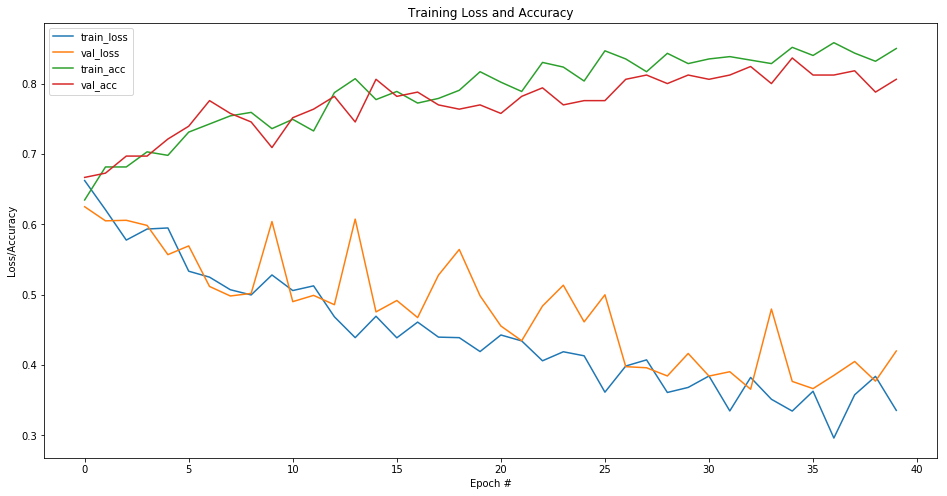

In [16]:
H=model.history
plt.rcParams['figure.figsize'] = 16, 8
plt.figure()
N = H.epoch[-1]+1
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")

### Save do modelo como model.h5

In [17]:
model.save("model_WSTUDIO.h5")

### Upload do modelo no IBM Watson Machine Learning - para export de API

In [18]:
# o modelo deve estar em formato .tar.gz para subir no WML
!tar -zcvf model_WSTUDIO.tar.gz model_WSTUDIO.h5

model_WSTUDIO.h5


In [19]:
# Credenciais do Watson Machine Learning
wml_credentials = {
  "apikey": "p5INbMkXdfG-qLYDVnk_ROeX6CGnO4ZjWvCRe8Aqd0FJ",
  "iam_apikey_description": "Auto-generated for key 90ed576d-3d65-4183-85bb-87540d858eb5",
  "iam_apikey_name": "wdp-writer",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
  "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/5086f0d78cb04b3aabd7b046c5c84a10::serviceid:ServiceId-b8bc4703-8080-450e-b22d-796a604e677f",
  "instance_id": "a8f286bb-6e41-4ddf-a97b-340ffcd6d33e",
  "password": "33a1cc1e-1158-4486-924c-48e086ad159b",
  "url": "https://us-south.ml.cloud.ibm.com",
  "username": "90ed576d-3d65-4183-85bb-87540d858eb5"
}
client = WatsonMachineLearningAPIClient( wml_credentials )

# Definição de metadados do modelo (versao de python, framework, libs e etc)
sample_saved_model_filename = 'model_WSTUDIO.tar.gz'
metadata = {
    client.repository.ModelMetaNames.NAME              : 'TheZoo',
    client.repository.ModelMetaNames.FRAMEWORK_NAME    : 'tensorflow',
    client.repository.ModelMetaNames.FRAMEWORK_VERSION : '1.11',
    client.repository.ModelMetaNames.RUNTIME_NAME      : 'python',
    client.repository.ModelMetaNames.RUNTIME_VERSION   : '3.6',
    client.repository.ModelMetaNames.FRAMEWORK_LIBRARIES :  [{"name": "keras", "version": "2.2.4"}]
}


# Conexão com o WML
model_details = client.repository.store_model( sample_saved_model_filename, meta_props=metadata, training_data=None )

# Deploy do modelo
model_id = model_details["metadata"]["guid"]
model_deployment_details = client.deployments.create( artifact_uid=model_id, name="TheZoo" )

# Retrieve da URL da API para consumo da mesma
model_endpoint_url = client.deployments.get_scoring_url( model_deployment_details )
print("A URL de chamada da sua API é : ",model_endpoint_url)



#######################################################################################

Synchronous deployment creation for uid: '02c4ef3c-10ea-4caa-994e-03dcc9cfc4e9' started

#######################################################################################


INITIALIZING
DEPLOY_IN_PROGRESS.
DEPLOY_SUCCESS


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='aab63322-d564-477b-b8ea-731a139bd547'
------------------------------------------------------------------------------------------------


A URL de chamada da sua API é :  https://us-south.ml.cloud.ibm.com/v3/wml_instances/a8f286bb-6e41-4ddf-a97b-340ffcd6d33e/deployments/aab63322-d564-477b-b8ea-731a139bd547/online


### Chamada da API para teste

In [ ]:
# Download de imagem teste
!wget -O teste2.jpg https://www.dropbox.com/s/73fofwe566749sl/teste123.jpg?dl=0

{'fields': ['prediction', 'prediction_classes', 'probability'], 'values': [[[0.985950767993927, 0.012618234381079674, 0.005536532495170832], 0, [0.985950767993927, 0.012618234381079674, 0.005536532495170832]]]}

Imagem Classificada como :  Elephant

Probabilidades : 
	 Elephant  : 98.60 %
	


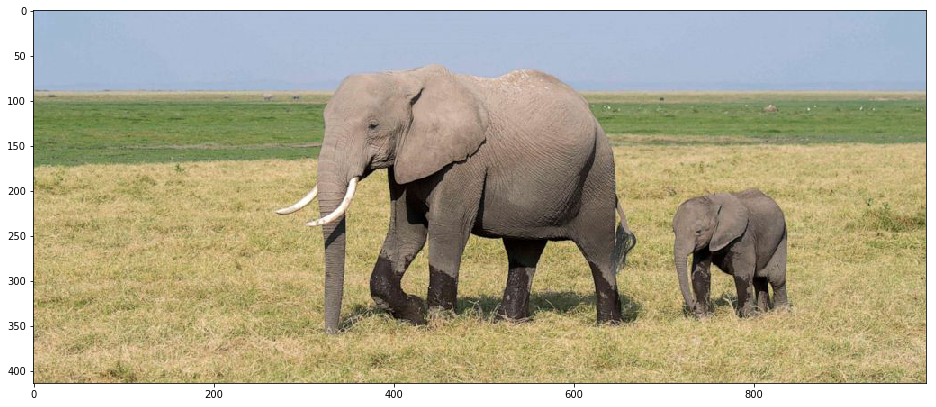

In [29]:
# Montagem da estrutura de JSON para chamada da API do WML
ai_parms = { "wml_credentials" : wml_credentials, "model_endpoint_url" : model_endpoint_url }

# Load da imagem de teste e pre-processing da mesma - para entrada na rede neural convolucional
image = Kimage.load_img("./DATASET/Elephant/1.elephant-1-gty-er-190828_hpMain_12x5_992.jpg")#0
# image = Kimage.load_img("./DATASET/Giraffe/1.giraffe_600.jpg")#1
# image = Kimage.load_img("./DATASET/Lion/1.Animal-cruelty-charges-laid-against-lion-farmer-800x400.jpg")#2
plt.imshow(image)
image = image.resize(size=(96,96))
image = img_to_array(image)
image = np.array(image, dtype="float") / 255.0
image = np.expand_dims(image,axis=0)
image = image.tolist()

# Chamada da função SCORE no modelo (inference)
model_payload = { "values" : image }
model_result = client.deployments.score( ai_parms["model_endpoint_url"], model_payload )
print(model_result)

print("\nImagem Classificada como : ", classes[model_result['values'][0][1]])

print("\nProbabilidades : \n\t",
      classes[model_result['values'][0][1]]," : %.2f" %(model_result['values'][0][0][0]*100),"%\n\t",
     )

# BOA SORTE